In [1]:
import sys
sys.path.append('..')

import numpy as np
from scipy import linalg

from matplotlib import pyplot as plt
%matplotlib inline

from filters import ExtendedKalmanFilter, UnscentedKalmanFilter
from smoothers import UnscentedKalmanSmoother

from util import feval, model_noisy, model_noiseless, plot_estimate, unscented_transform

_reseed = True
if _reseed:
    seed = np.random.randint(0, np.iinfo(np.int32).max)
    print(seed)
else:
    seed = 1597995089
np.random.seed(seed)

1189316673


# Unscented Kalman Filter Demo


...

### Predict
$x_{t|t-1}, P_{t|t-1} = \mathrm{UT}\left[f,x_{t-1}, u_t; \xi_t\right]$


Where $\mathrm{UT}[\cdot]$ is the unscented transform.

### Update

$\tilde{y}_{t|t-1}, P^{(y)}_t, P^{(xy)}_t = \mathrm{UT}\left[h,x_{t|t-1},u_t;\nu_t\right]$

$\mathbf{K}_t = P^{(xy)}_t \left( P^{(y)}_t\right)^{-1}$

$x_{t|t} = x_{t|t-1} + \mathbf{K}_t(y_t - \tilde{y}_{t|t-1})$

$P_{t|t} = P_{t|t-1} - \mathbf{K}_tP^{(y)}_t\mathbf{K}^T$

## 1-D Example

...

$x_t = \left[\theta_t, \omega_t, a_t\right]^\text{T}$ and $y_t = [x]$

The respective process models are:

$f(\cdot) = \begin{bmatrix}\theta_t + \omega_t \\ \omega_t \\ a_t\end{bmatrix} \qquad h(\cdot) = a_t\sin\theta_t$

Unscented transform parameters for the distribution are: $\alpha = 1.0,\ \beta = 2.0,\ \kappa = 3 - n_x = 0$


In [2]:
# Number of observations
n_t = 500
# Time interval
#dt = 5./n_t
dt = 0.01

# Process model
f = lambda x: np.array([[x[0,0] + dt*x[1,0], x[1,0], x[2,0]]]).T

# Observation model
h = lambda x: x[2,0] * np.sin(x[0,0])

some text

In [3]:
# Process noise covariance
Q = np.array([[0.2*(dt**3)/3., 0.2*(dt**2)/2, 0],[0.2*(dt**2)/2, 0.2*dt, 0], [0, 0, 0.1*dt]])

# Observation noise covariance
R = np.array([[1]])

# Initial state and estimation error covariance
x0 = np.array([[0., 10. , 1.]]).T
P0 = np.diag(np.array([2., 3., 1.]))#3. * np.eye(x0.shape[0])

print(P0)
# Data dimensions
n_x = 3
n_y = 1

[[ 2.  0.  0.]
 [ 0.  3.  0.]
 [ 0.  0.  1.]]


Model the systems

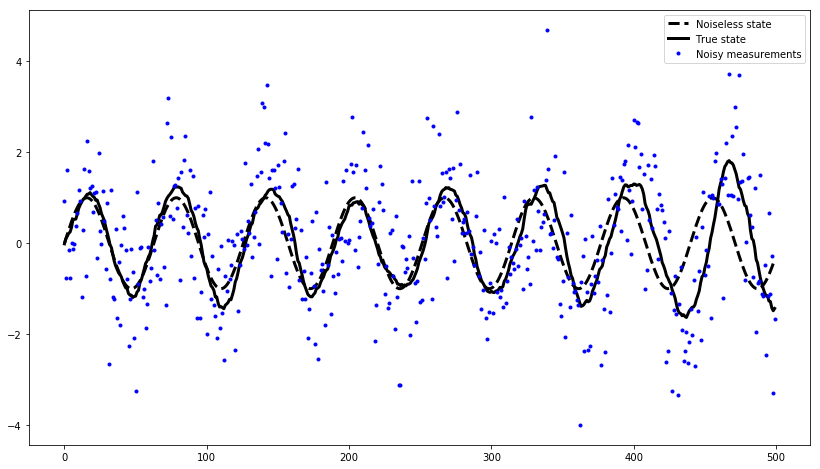

In [4]:
x_noiseless, y_noiseless = model_noiseless(x0, f=f, h=h, n=n_t)
x_true, y_true, y_noisy = model_noisy(x0, f, Q, None, h, R, n=n_t)

plt.figure(figsize=(14, 8))

plt.plot(y_noiseless.T, 'k--',lw=3)
plt.plot(y_true.T, 'k-',lw=3)
plt.plot(y_noisy.T,'b.')

plt.legend(labels=['Noiseless state', 'True state', 'Noisy measurements'])

In [5]:
ukf = UnscentedKalmanFilter(x0, P0, f, Q, h, R, {'alpha': 1, 'beta':2})

x_estimate = np.zeros_like(x_true)
P_estimate = np.zeros((n_x, n_x, n_t))
y_estimate = np.zeros_like(y_true)
P_yestimate = np.zeros((n_y, n_y, n_t))

x_estimate[:,0]   = x0.ravel()
P_estimate[:,:,0]  = P0

y_estimate[:,0], P_yestimate[:,:,0], _ = unscented_transform(x0, P0, h)
P_yestimate[:,:,0] += R

for i_ in range(1, n_t):
    ukf.predict()
    ukf.update(y_noisy[:,i_])
    
    x_estimate[:,i_] = ukf.state['expected'].ravel()
    P_estimate[:,:,i_] = ukf.state['err_cov']
    
    y_estimate[:,i_], P_yestimate[:,:,i_], _ = unscented_transform(x_estimate[:,i_][:,None], P_estimate[:,:,i_], h)
    P_yestimate[:,:,i_] += R

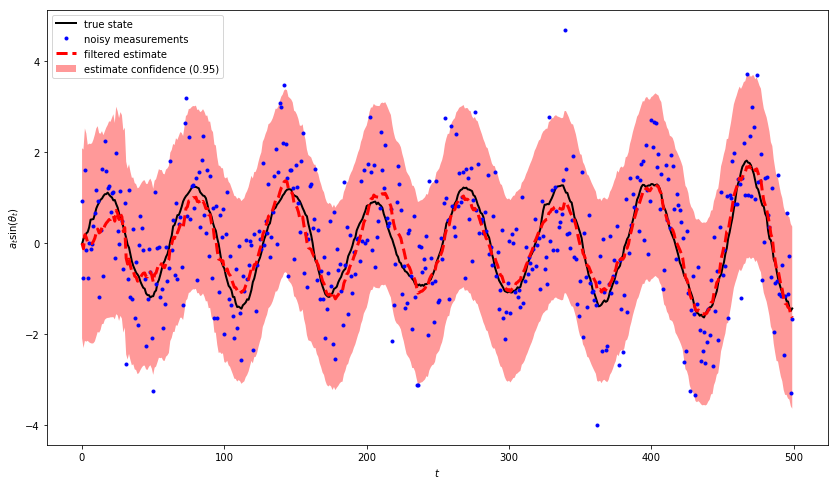

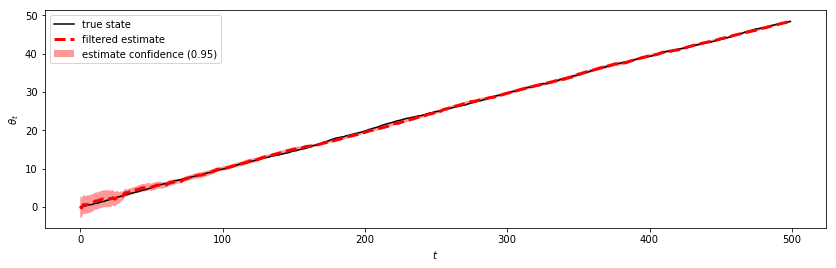

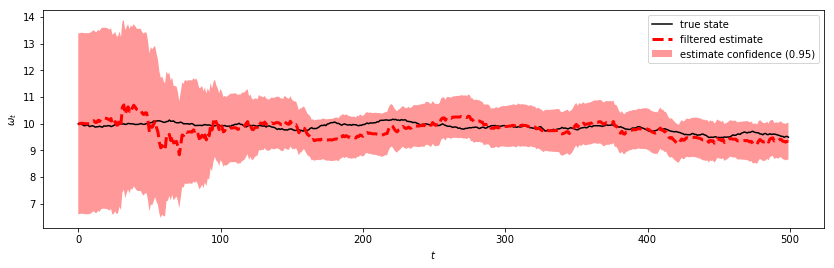

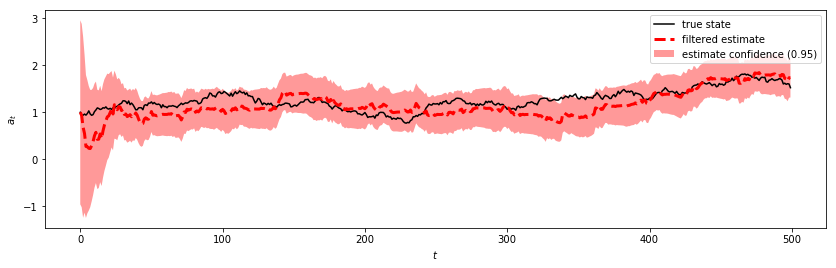

In [6]:
plt.figure(figsize=(14, 8))

plt.plot(y_true.T, 'k-', lw=2)
plt.plot(y_noisy.T, 'b.')

plot_estimate(np.arange(n_t), y_estimate[0,:], P_yestimate[0,0,:])

plt.xlabel('$t$')
plt.ylabel(r'$a_t\sin(\theta_t)$')
plt.legend(labels=['true state','noisy measurements','filtered estimate','estimate confidence (0.95)'])

lbl = [r'$\theta_t$',r'$\omega_t$',r'$a_t$']
for i in range(3):
    plt.figure(figsize=(14,4))
    plt.plot(x_true[i,:].ravel(),'k-')
    
    plot_estimate(np.arange(n_t), x_estimate[i,:], P_estimate[i,i,:])
    plt.xlabel('$t$')
    plt.ylabel(lbl[i])
    plt.legend(labels=['true state','filtered estimate','estimate confidence (0.95)'])

In [7]:
urts = UnscentedKalmanSmoother.from_filter(ukf)
states = urts.smooth()

x_smoothed = np.zeros_like(x_true)
P_smoothed = np.zeros((n_x, n_x, n_t))
y_smoothed = np.zeros_like(y_true)
P_ysmoothed = np.zeros((n_y, n_y, n_t))

for i_ in range(n_t):
    x_smoothed[:,i_] = states[i_]['expected'].ravel()
    P_smoothed[:,:,i_] = states[i_]['err_cov']
    
    y_smoothed[:,i_], P_ysmoothed[:,:,i_], _ = unscented_transform(x_smoothed[:,i_][:,None], P_smoothed[:,:,i_], h)
    P_ysmoothed[:,:,i_] += R

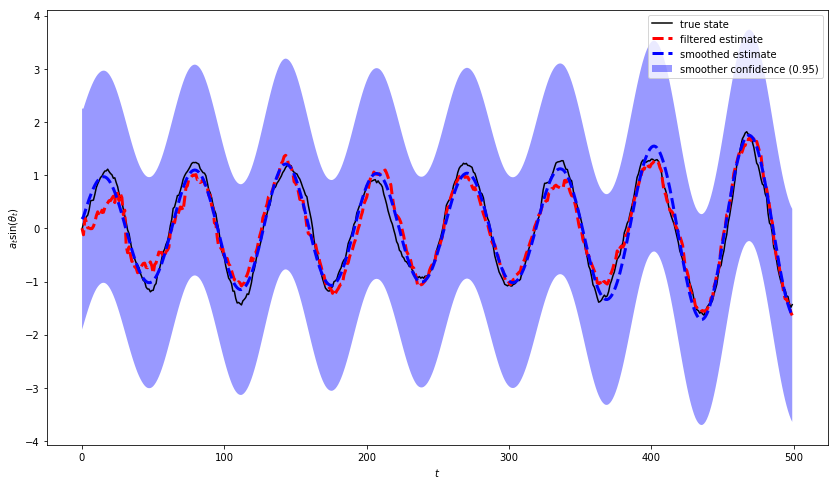

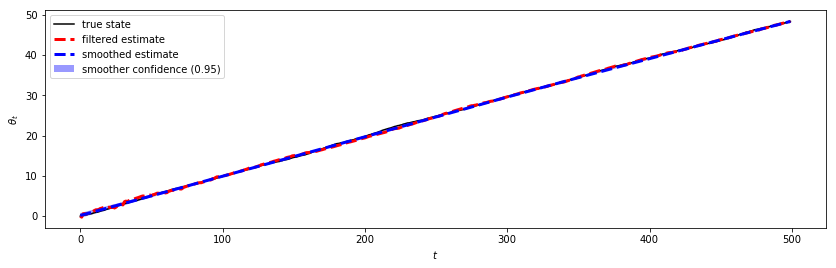

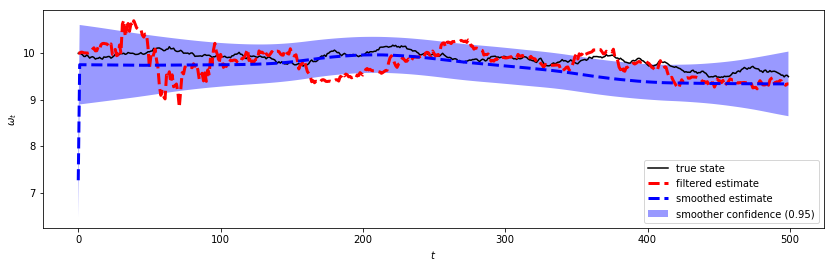

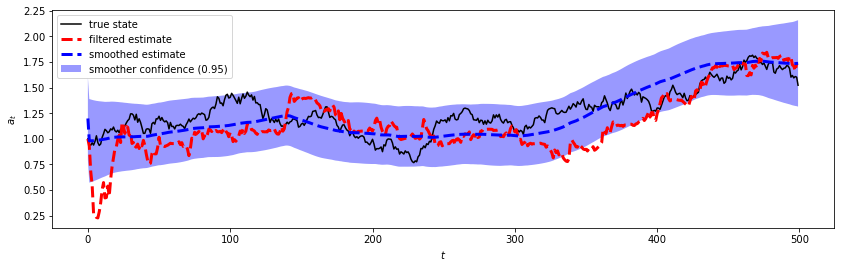

In [8]:
plt.figure(figsize=(14, 8))

plt.plot(y_true.T, 'k-')
plt.plot(y_estimate.T, 'r--', lw=3)
    
plot_estimate(np.arange(n_t), y_smoothed, P_ysmoothed,'b')

plt.xlabel('$t$')
plt.ylabel(r'$a_t\sin(\theta_t)$')
plt.legend(labels=['true state','filtered estimate','smoothed estimate','smoother confidence (0.95)'])

lbl = [r'$\theta_t$',r'$\omega_t$',r'$a_t$']
for i in range(3):
    plt.figure(figsize=(14,4))
    plt.plot(x_true[i,:].ravel(),'k-')
    plt.plot(x_estimate[i,:].ravel(), 'r--',lw=3)
    
    plot_estimate(np.arange(n_t), x_smoothed[i,:], P_smoothed[i,i,:],'b')
    
    plt.xlabel('$t$')
    plt.ylabel(lbl[i])

    plt.legend(labels=['true state','filtered estimate','smoothed estimate','smoother confidence (0.95)'])

In [9]:
# Jacobian (EKF only)
Fx = lambda x: np.array([[1., dt, 0.], [0., 1., 0.], [0., 0., 1.]])
Hx = lambda x: np.array([[x[2,0]*np.cos(x[0,0]), 0., np.sin(x[0,0])]])

ekf = ExtendedKalmanFilter(x0, P0, f, Q, Fx, None, h, R, Hx, None)

ekf_x_estimate = np.zeros_like(x_true)
ekf_P_estimate = np.zeros((n_x, n_x, n_t))
ekf_y_estimate = np.zeros_like(y_true)
ekf_P_yestimate = np.zeros((n_y, n_y, n_t))

ekf_x_estimate[:,0]   = x0.ravel()
ekf_y_estimate[:,0]    = feval(h, x0).ravel()
ekf_P_estimate[:,:,0]  = P0
ekf_P_yestimate[:,:,0] = feval(Hx, x0) @ P0 @ feval(Hx, x0).T + R

for i_ in range(1, n_t):
    ekf.predict()
    ekf.update(y_noisy[:,i_])
    
    ekf_x_estimate[:,i_] = ekf.state['expected'].ravel()
    ekf_P_estimate[:,:,i_] = ekf.state['err_cov']
    
    ekf_y_estimate[:,i_] = feval(h, ekf_x_estimate[:,i_].reshape(n_x,1)).ravel()
    ekf_H_ = feval(Hx, ekf_x_estimate[:,i_].reshape(x0.shape))
    ekf_P_yestimate[:,:,i_] = np.atleast_2d(ekf_H_ @ ekf_P_estimate[:,:,i_] @ ekf_H_.T + R)

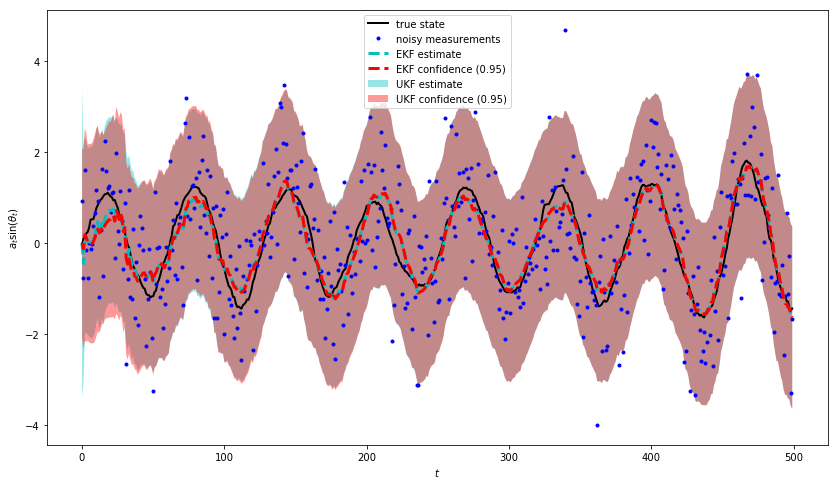

In [10]:
plt.figure(figsize=(14, 8))

plt.plot(y_true.T, 'k-', lw=2)
plt.plot(y_noisy.T, 'b.')

#plt.plot(ekf_y_estimate.T,'y-',lw=3)
plot_estimate(np.arange(n_t), ekf_y_estimate[0,:], ekf_P_yestimate[0,0,:],'c')
plot_estimate(np.arange(n_t), y_estimate[0,:], P_yestimate[0,0,:])
#plt.plot(y_estimate.T, 'r--',lw=3)

plt.xlabel('$t$')
plt.ylabel(r'$a_t\sin(\theta_t)$')
plt.legend(labels=['true state','noisy measurements','EKF estimate', 'EKF confidence (0.95)','UKF estimate', 'UKF confidence (0.95)'])



In [11]:
upr = UnscentedKalmanFilter(x0, P0, f, Q, h, R)

# Ratio of filter to prediction 0.8:0.2 
n_s = int(np.fix(0.8 * n_t))

x_predict = np.zeros((n_x, n_t-n_s))
P_predict = np.zeros((n_x, n_x, n_t-n_s))
y_predict = np.zeros((n_y, n_t-n_s))
P_ypredict = np.zeros((n_y, n_y, n_t-n_s))

for i_ in range(1, n_s):
    upr.predict()
    upr.update(y_noisy[:,i_])
    
for i_ in range(0,n_t-n_s):
    upr.predict()
    x_predict[:,i_]   = upr.state['expected'].ravel()
    P_predict[:,:,i_] = upr.state['err_cov']
    
    y_predict[:,i_], P_ypredict[:,:,i_], _ = unscented_transform(x_predict[:,i_][:,None], P_predict[:,:,i_], h)
    P_ypredict[:,:,i_] += R

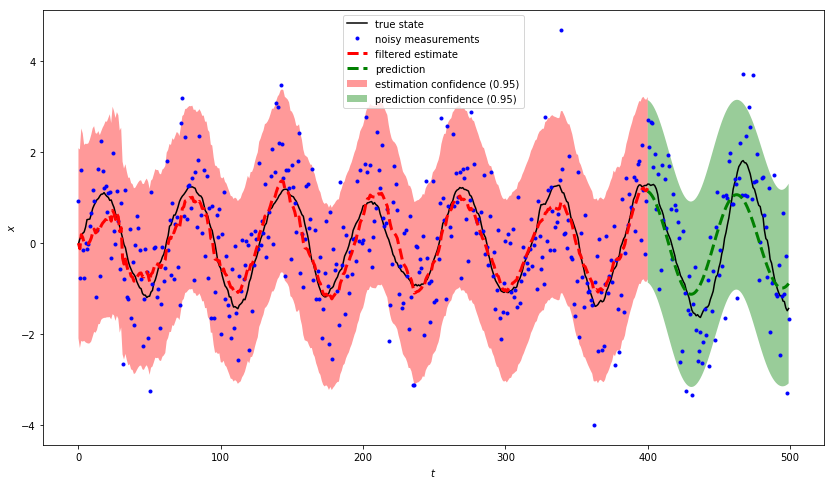

In [12]:
plt.figure(figsize=(14, 8))

plt.plot(y_true.T, 'k-')
plt.plot(y_noisy.T, 'b.')

# Plot filter estimation (red)
plot_estimate(np.arange(n_s+1), y_estimate[0,0:n_s+1], P_yestimate[0,0,0:n_s+1])
# Plot prediction
plot_estimate(np.arange(n_s,n_t), y_predict, P_ypredict, 'g')

plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend(labels=['true state', 'noisy measurements', 'filtered estimate','prediction','estimation confidence (0.95)','prediction confidence (0.95)'])

In [13]:
from util import rmse

err_ukf = rmse(np.vstack([x_true,y_true]),np.vstack([x_estimate, y_estimate]))
err_ekf = rmse(np.vstack([x_true,y_true]),np.vstack([ekf_x_estimate, ekf_y_estimate]))
err_urts = rmse(np.vstack([x_true,y_true]),np.vstack([x_smoothed, y_smoothed]))

lbl = ['x[0]','x[1]','x[2]','y[0]']

print('_rmse_|___ukf___|___ekf___|__urts_')
for i in range(4):
    print(' %s | %6.5f | %6.5f | %6.5f' % (lbl[i], err_ukf[i], err_ekf[i], err_urts[i]) )
    
# Prediction error
err_upr = rmse(np.vstack([x_true[:,n_s:n_t],y_true[:,n_s:n_t]]),np.vstack([x_predict, y_predict]))
print('')
print('_rmse_|___upr__')
for i in range(4):
    print(' %s | %6.5f' % (lbl[i], err_upr[i]) )

_rmse_|___ukf___|___ekf___|__urts_
 x[0] | 0.27386 | 0.24407 | 0.17833
 x[1] | 0.30475 | 0.27439 | 0.26436
 x[2] | 0.23501 | 0.28498 | 0.13785
 y[0] | 0.25687 | 0.25108 | 0.17475

_rmse_|___upr__
 x[0] | 0.49208
 x[1] | 0.21579
 x[2] | 0.43183
 y[0] | 0.56202
